# CORRELATION

In [1]:
# Libraries
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math
import plotly.plotly as py
import plotly.graph_objs as go

In [2]:
# read test, farm, ingredient and address data
test_data = pd.read_csv("New_test_data.txt", sep="\t", header=None)
farm_data = pd.read_excel('FarmaciBovinoSuini_20170721_converted.xlsx')
ingredient_table = pd.read_excel('Active_Ingredient_EN_IT.xlsx') # english-italian active ingredient 
address_data = pd.read_excel('Farm_adddress.xlsx') # address data

### Data preparation

In [3]:
# give header to test data
test_data.rename(index=str, columns={0: "Anno", 3:"Data_inizio", 4:"Data_fino", 5: "Medicine_type", 6:"Active_ingredient", 7:"Farm_ID", 8:"Result", 9:"Result_exp", 10:"Bacteria", 11:"Animal_code", 12:"Animal_kind"}, inplace=True) 
# upper case for unique results
farm_data['PrincipioAttivo'] = farm_data['PrincipioAttivo'].str.upper()
farm_data['IdAllevamento'] = farm_data['IdAllevamento'].str.upper()
farm_data['RagioneSociale'] = farm_data['RagioneSociale'].str.upper()
farm_data['Indirizzo'] = farm_data['Indirizzo'].str.upper()
farm_data['Localita'] = farm_data['Localita'].str.upper()
test_data['Farm_ID'] = test_data['Farm_ID'].str.upper()
test_data['Active_ingredient'] = test_data['Active_ingredient'].str.upper()
# dtype changes
farm_data['DataFineSomministrazione'] = pd.to_datetime(farm_data['DataFineSomministrazione'])
# ingredient table preparation
ingredient_table.columns = ['PrincipioAttivo', 'Active_Ingredient_IT']
# add italian names of active ingredients to the farm data
farm_data = pd.merge(farm_data, ingredient_table, on='PrincipioAttivo', how='outer')
# add extra 2 year columns to farm data (medicine use year and farm situation) for a continous result
farm_data['Year_medicine_use'] = farm_data['DataInizioSomministrazione'].dt.year
farm_data['Year_farm_situation'] = farm_data['DataInizioProduzione'].dt.year
# as much as it is possible, I will fix the name of columns for different data set
farm_data.rename(columns={'PrincipioAttivo':'Active_ingredient', 'IdAllevamento': 'Farm_ID', 'CategoriaFarmacologica':'Medicine_type'}, inplace=True)
address_data.rename(columns={'Allevix':'Farm_ID'}, inplace=True)

Since the farm data is only on 'pork', I need to use only the test data of porks. 
On the other hand, the test results only for antibiotics. So, I also filter the farm data for antibiotics

In [4]:
# test data has to be composed only from pork data
test_data_pork = test_data.loc[test_data['Animal_kind'].isin(['SUINO', 'SUINO - SVEZZAMENTO', 'SUINO - SOTTOSCROFA', 'SUINO - MAGRONE', 'SUINO - SCROFETTA', 'SUINO - INGRASSO', 'SUINO - SCROFA', 'SUINO - VERRO', 'SUINO DI RAZZA MORA', 'SUINO DI RAZZA CINTA SENESE'])]
# farm data has to be composed only with antibiotic
farm_data_antibiotic = farm_data[farm_data.Medicine_type == 'antimicrobial']

# FARM DATA ANAYLSE

### YEARLY TOTAL MG USED 

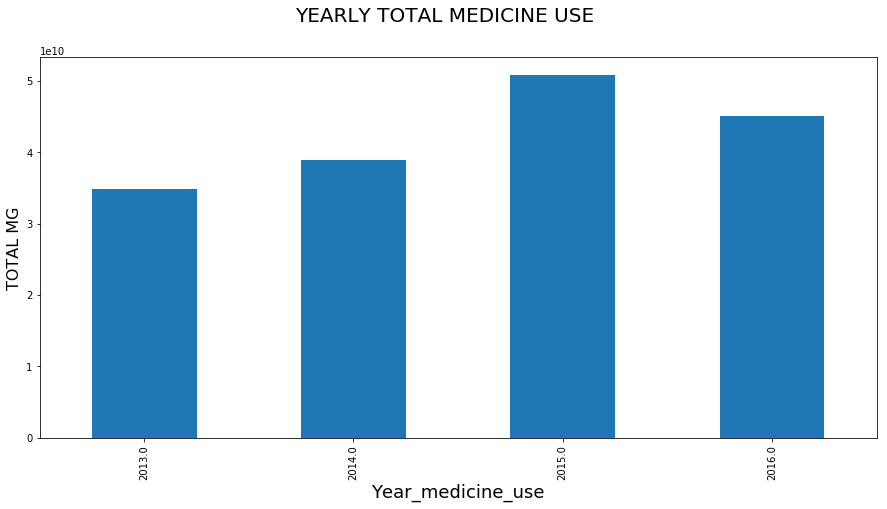

In [5]:
# plot data
fig, ax = plt.subplots(figsize=(15,7))
fig.suptitle('YEARLY TOTAL MEDICINE USE', fontsize=20)
plt.xlabel('YEAR', fontsize=18)
plt.ylabel('TOTAL MG', fontsize=16)
# use unstack()
farm_data_antibiotic.groupby('Year_medicine_use')['PrincipioSomministratoMg'].agg('sum').plot.bar()

### YEARLY TOTAL MG USED BY ACTIVE INGREDIENT 

[Text(0,0.5,'TOTAL MG'), Text(0.5,0,'YEAR')]

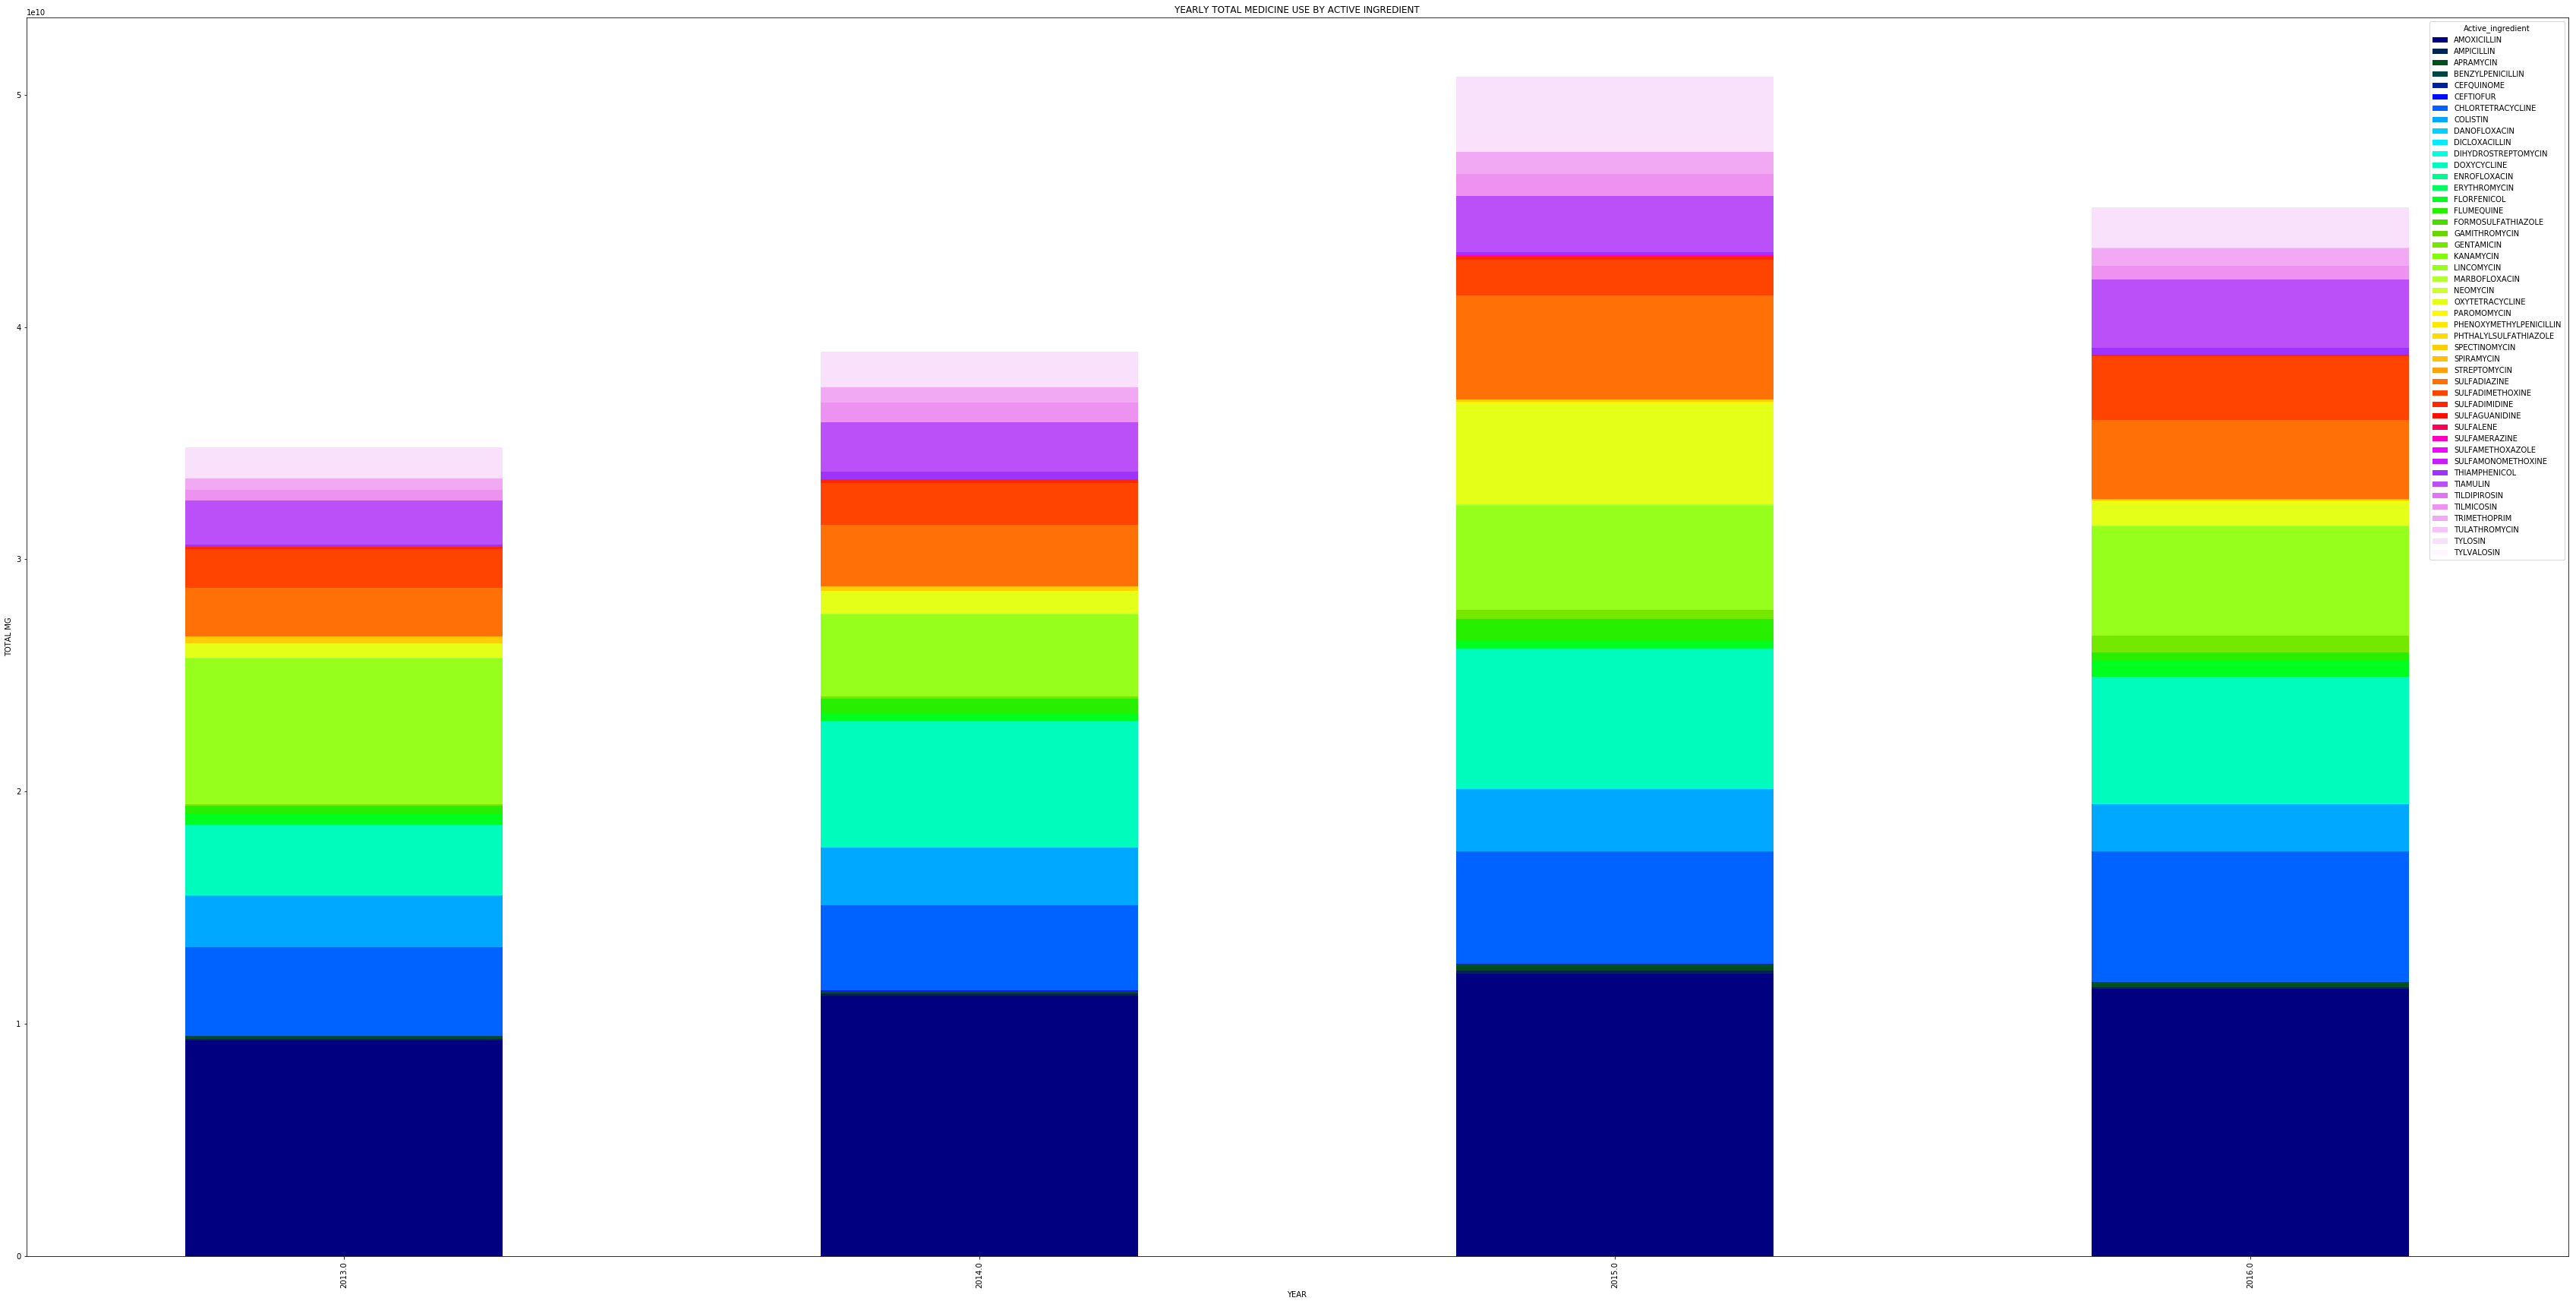

In [6]:
total_medicine_use = farm_data_antibiotic.groupby(['Year_medicine_use', 'Active_ingredient'])['PrincipioSomministratoMg'].agg('sum')
# plot data
ax = total_medicine_use.unstack().plot(kind='bar', figsize=(60,30), stacked=True, colormap='gist_ncar', title='YEARLY TOTAL MEDICINE USE BY ACTIVE INGREDIENT')
ax.set(xlabel="YEAR", ylabel="TOTAL MG")

In [7]:
#total_medicine_use.to_csv("total_medicine_use.csv", sep='\t') # save the table for Tableau.

## NUMBER OF ANIMAL BY YEAR BY FARM

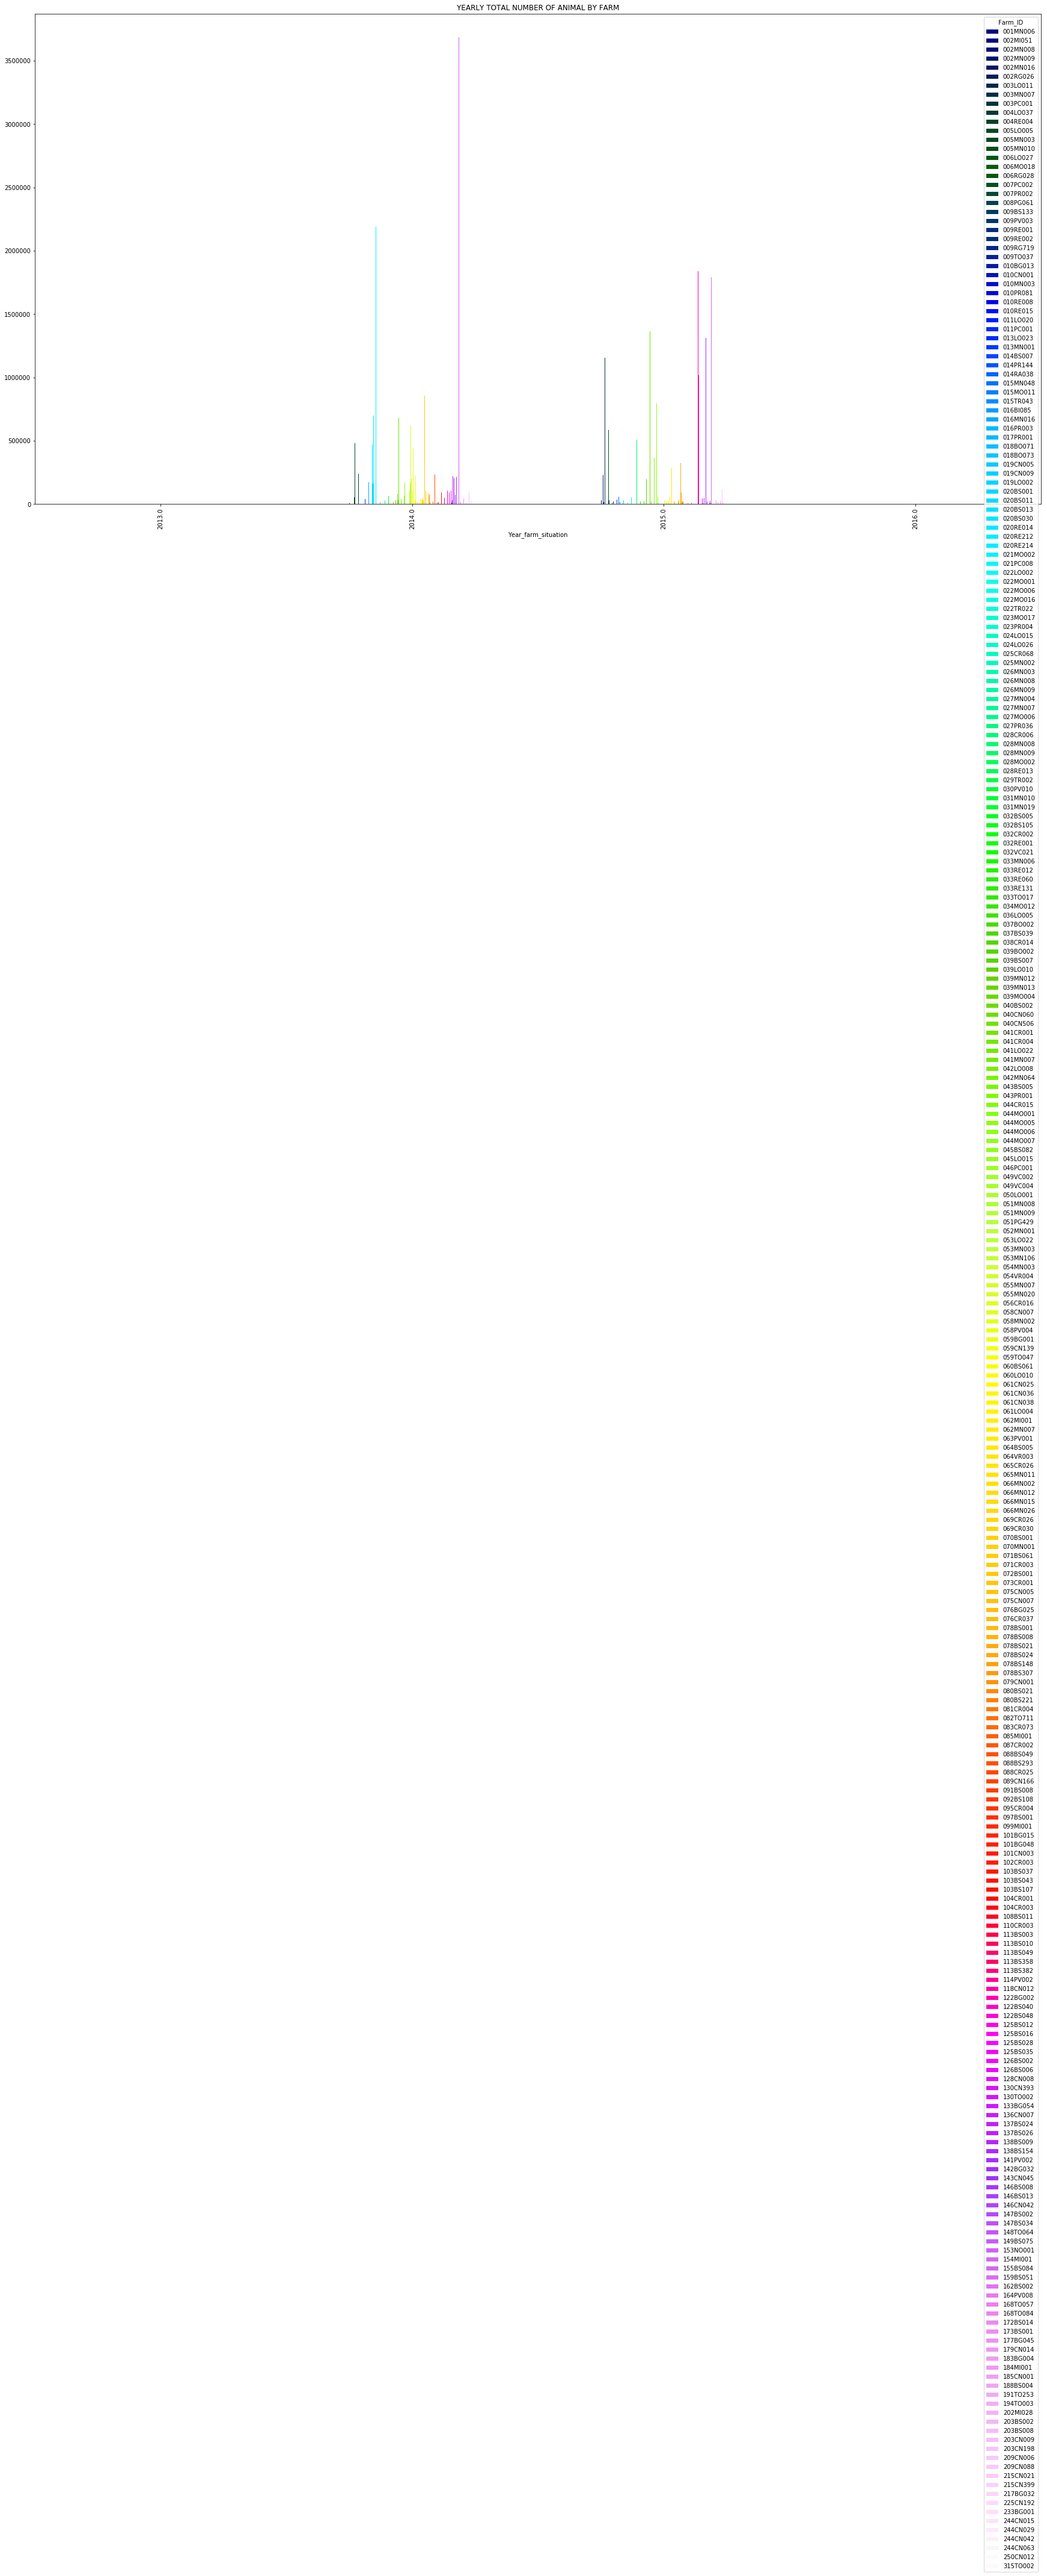

In [8]:
farm_data_antibiotic.groupby(['Year_farm_situation', 'Farm_ID'])['N suini'].sum().unstack().plot(kind='bar', figsize=(30,15), colormap='gist_ncar', title='YEARLY TOTAL NUMBER OF ANIMAL BY FARM')

# TEST DATA ANAYSE

### YEARLY TOTAL NUMBER OF TEST

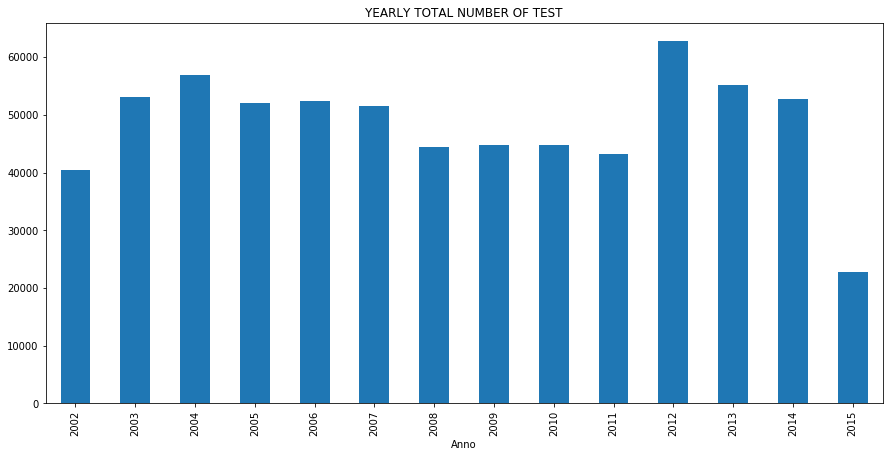

In [9]:
test_data_pork.groupby('Anno').Result.count().plot(kind='bar', figsize=(15,7), title='YEARLY TOTAL NUMBER OF TEST')

### YEARLY TOTAL NUMBER OF TEST BY ACTIVE INGREDIENT

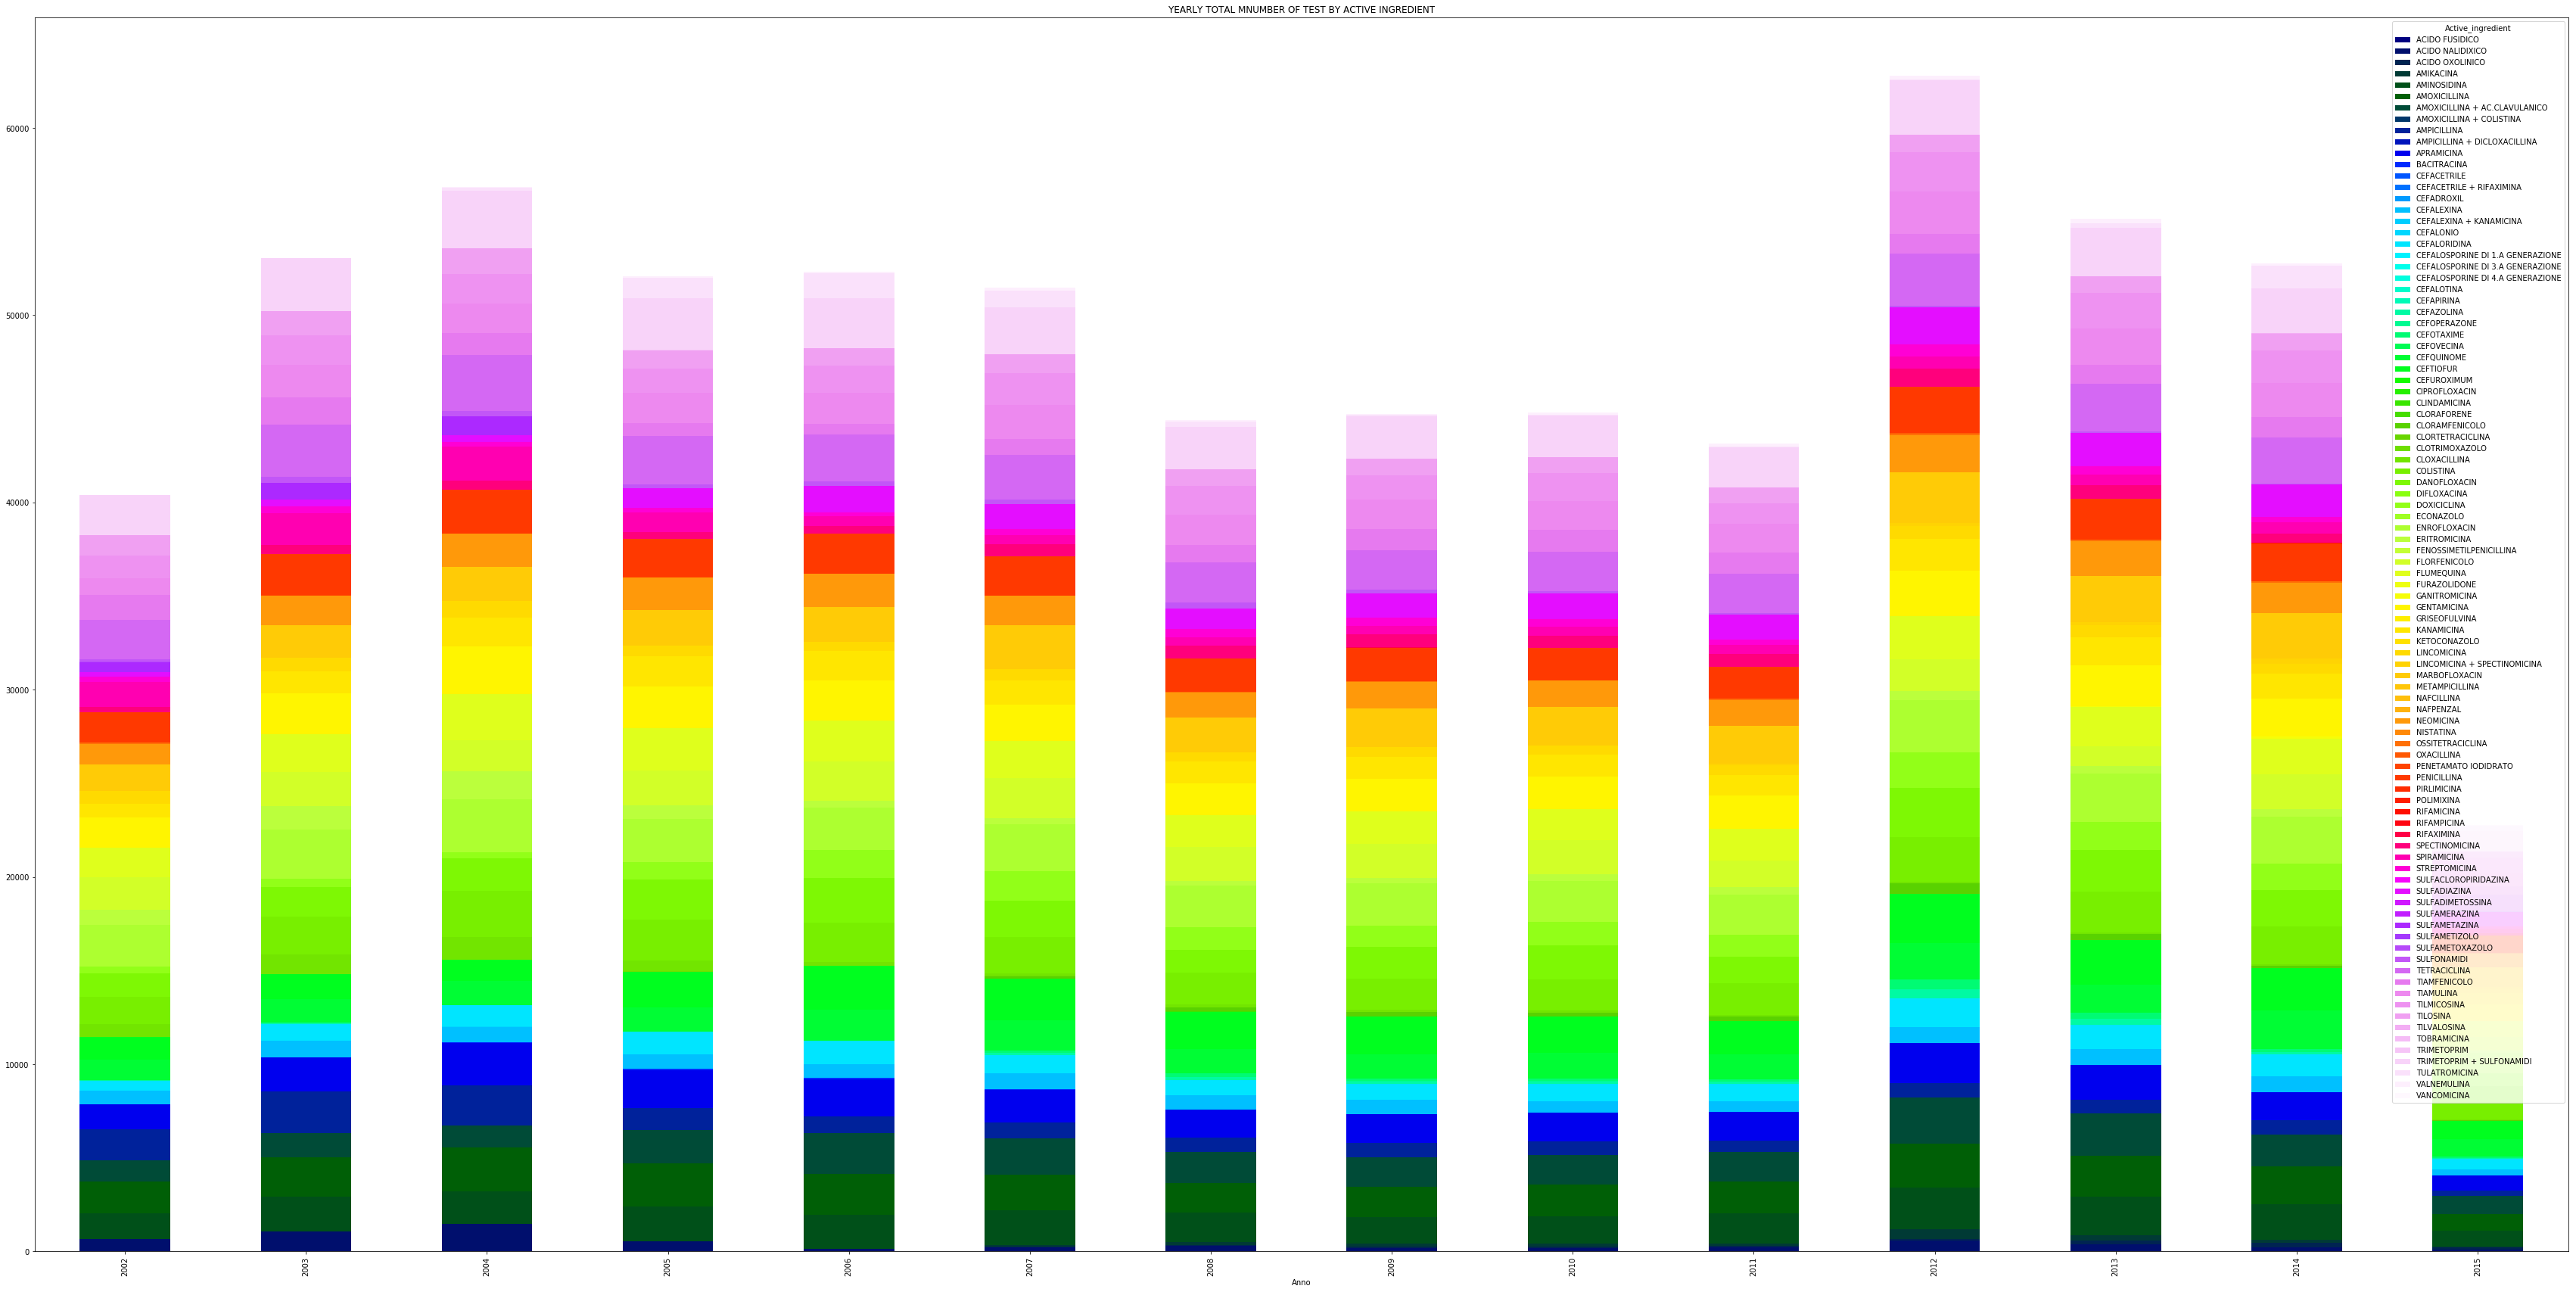

In [10]:
test_data_pork.groupby(['Anno', 'Active_ingredient']).Result.count().unstack().plot(kind='bar', figsize=(60,30), stacked=True, colormap='gist_ncar', title='YEARLY TOTAL MNUMBER OF TEST BY ACTIVE INGREDIENT')

### YEARLY TOTAL NUMBER OF TEST RESULT WITH "R"

In [11]:
test_data_pork_R = test_data_pork[test_data_pork.Result == 'R']

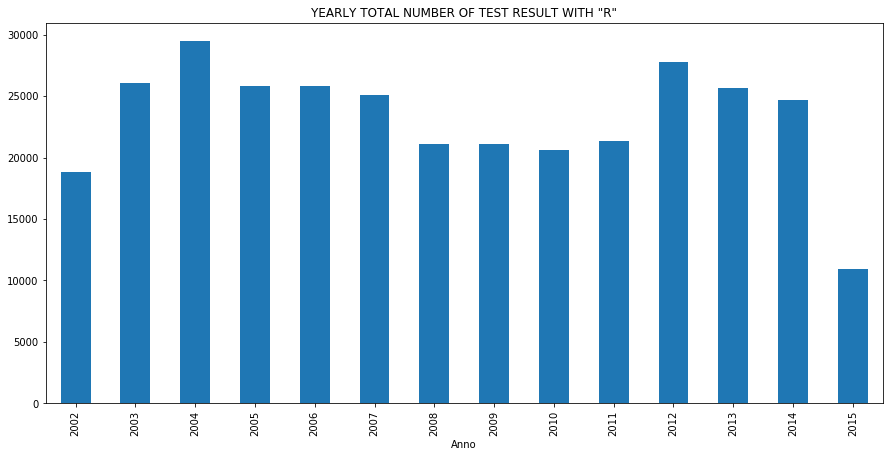

In [12]:
test_data_pork_R.groupby('Anno').Result.count().plot(kind='bar', figsize=(15,7), title='YEARLY TOTAL NUMBER OF TEST RESULT WITH "R"')

### YEARLY TOTAL NUMBER OF TEST RESULT WITH "R" BY ACTIVE INGREDIENT

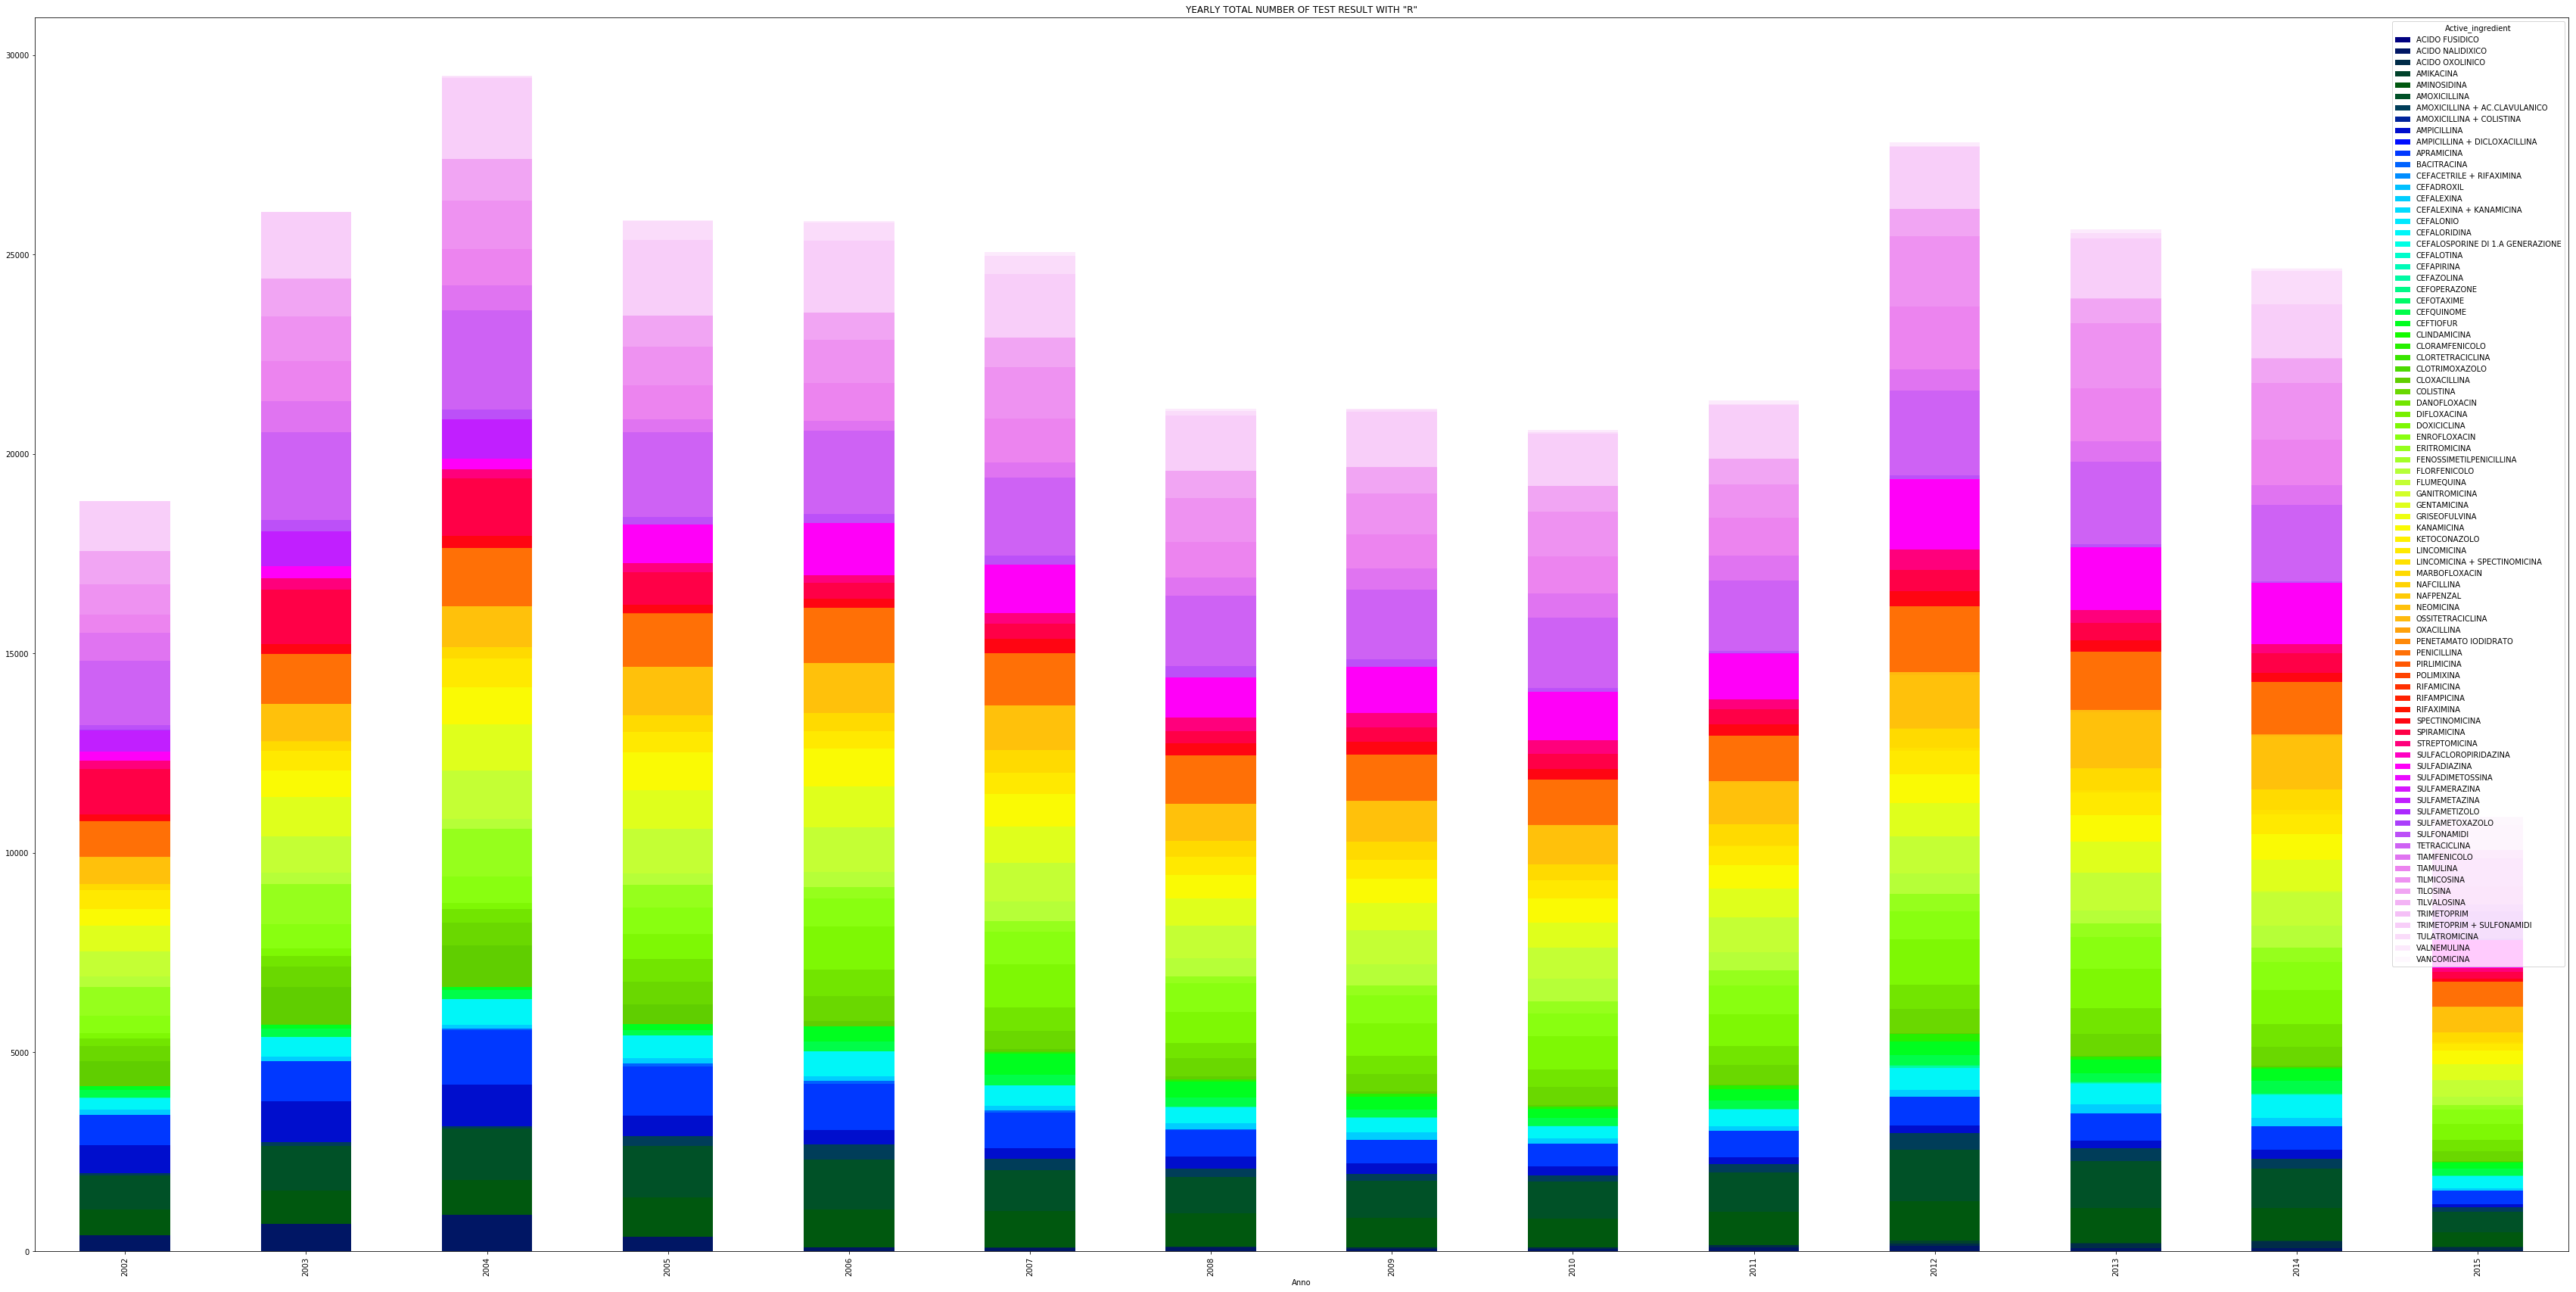

In [13]:
test_data_pork_R.groupby(['Anno', 'Active_ingredient']).Result.count().unstack().plot(kind='bar', figsize=(60,30), stacked=True, colormap='gist_ncar', title='YEARLY TOTAL NUMBER OF TEST RESULT WITH "R"')

### NRMALIZED R RESULTS

In [14]:
denominator = test_data_pork.groupby('Anno').Result.count()
numerator = test_data_pork_R.groupby('Anno').Result.count()
normalized_test_data_R = numerator/denominator

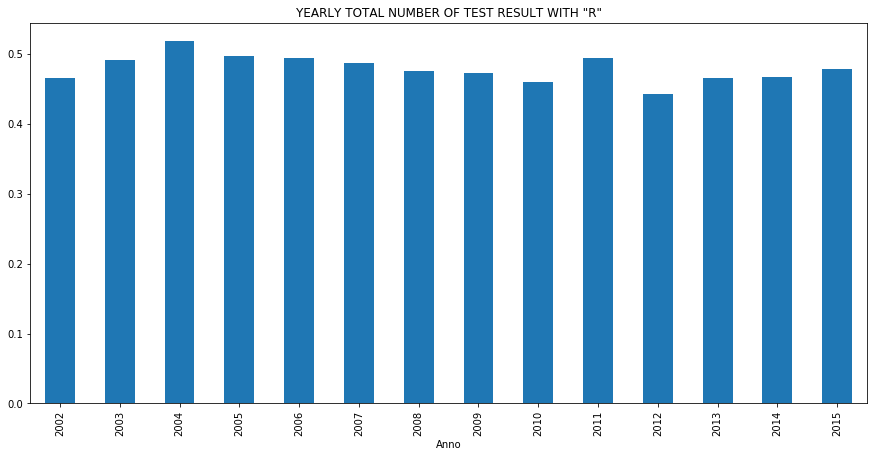

In [15]:
normalized_test_data_R.plot(kind='bar', figsize=(15,7), title='YEARLY TOTAL NUMBER OF TEST RESULT WITH "R"')

# ADDRESS DATA HAVERSINE (DO NOT USE)

In [16]:
# function to calculate heversine distance
def haversine_distance(origin, destination):
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371 # km

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c

    return d

In [17]:
distances=[]
for i in range(len(address_data)):
    lat1 = address_data.loc[i:i,'Latitude'].values[0]
    lon1 = address_data.loc[i:i,'Longitude'].values[0]
    lat2 = address_data.loc[i+1:i+1,'Latitude'].values[0]
    lon2 = address_data.loc[i+1:i+1,'Longitude'].values[0]
    distances.append(haversine_distance((lat1,lon1),(lat2,lon2)))

IndexError: index 0 is out of bounds for axis 0 with size 0

In [18]:
distances

[146.95187679462555,
 58.63267560092966,
 105.9513592623109,
 0.0,
 0.0,
 0.0,
 39.20432228441531,
 95.65944314457803,
 68.20658717829153,
 48.416810496549274,
 41.08394636672786,
 15.47192314711463,
 0.0,
 71.84559166149617,
 46.011425931172184,
 37.553829152066854,
 56.81181764335773,
 2.952000422205223,
 13.137046685653857,
 0.0,
 0.0,
 56.30234255594436,
 76.8407104121366,
 129.83643454599866,
 103.30052025326883,
 11.643905417496473,
 156.69130598082742,
 136.64737590698945,
 45.47051077668974,
 23.35674209444575,
 72.95315282976345,
 45.48580716268611,
 20.827874676002715,
 4.013268540118815,
 7.152240351227261,
 16.1788067488668,
 15.971344603917624,
 14.440474952929886,
 21.897657555311024,
 16.149375168880752,
 17.621471296916383,
 24.252057817198917,
 11.55570619437157,
 42.867757911191916,
 32.69789302502507,
 19.25474989764737,
 49.32335950360173,
 11.756129782532232,
 53.348530661164475,
 5.574154643247843,
 13.68715065445367,
 6.566679527905169,
 13.923195864320062,
 44.5

# ALTERNATIVE PLOT FUNCTION (DO NOT USE)

In [19]:
def plot_test_results(active_ingredients):
    traces = []
    for active_ingredient in active_ingredients: 
        time = list(range(len(test_data_pork_R['Anno']))) # time values; 
        traces.append(go.Scatter(x=time, y=total_test_result_R.values[:0], mode='lines'))

    data=go.Data(traces)

    layout=go.Layout(showlegend=False)
    
    figure = go.Figure(data=data, layout=layout) # generate plot figure;
    plotly.offline.iplot(figure, filename = 'Test Data') # plot figure;

In [20]:
#plot_test_results(total_test_R.index.get_level_values('Active_ingredient'))

# Number of farm which has test results for every year

In [21]:
fullList=[] # the list of farm which have the results for each year
for i in range(len(test_data_pork.groupby(['Farm_ID']).Anno.unique())):
    if len(test_data_pork.groupby(['Farm_ID']).Anno.unique().values[i])== len(test_data_pork.Anno.unique()):
        fullList.append(test_data_pork.groupby(['Farm_ID']).Anno.unique().index.get_values()[i])

In [22]:
len(fullList) # only 12 of Farms has the test for each year 

12

In [23]:
fullList

['003MO004',
 '009PV003',
 '019MN001',
 '031MN222',
 '039CR002',
 '045MO024',
 '051MN003',
 '054VR003',
 '066MN002',
 '083CR002',
 '097BS001',
 '113CR003']

In [24]:
test_data_pork_full = test_data_pork[test_data_pork.Farm_ID.isin(fullList)] # dataframe with only the farm which
# has test for each year

In [ ]:
#test_data_pork_full.to_csv("test_data_pork_full.csv", sep='\t') # Results are in Tableau

# About Bacteria

In [25]:
Bacteria_active_ingredient = test_data_pork.groupby('Bacteria')['Active_ingredient']

In [26]:
Bacteria_active_ingredient.describe()

,count,unique,top,freq
Bacteria,,,,
Ceppo non identificabile,55,28,SULFADIAZINA,3
Acinetobacter baumannii,20,10,ENROFLOXACIN,2
Actinobacillus equuli/sh.equirulis,19,19,AMOXICILLINA + AC.CLAVULANICO,1
Actinobacillus pleuropneumoniae,8122,43,ENROFLOXACIN,433
Actinobacillus pleuropneumoniae biotipo 1,24397,56,TRIMETOPRIM + SULFONAMIDI,1156
Actinobacillus pleuropneumoniae biotipo 2,8004,54,TETRACICLINA,389
Actinobacillus pleuropneumoniae sierotipo 1,53,28,FLORFENICOLO,3
Actinobacillus pleuropneumoniae sierotipo 2,1346,34,ENROFLOXACIN,71
Actinobacillus pleuropneumoniae sierotipo 4,19,19,AMOXICILLINA + AC.CLAVULANICO,1


In [27]:
test_data_pork.groupby('Anno')['Bacteria'].describe() # The most tested bacteria for each year are
# E.Coli and Salmonella

,count,unique,top,freq
Anno,,,,
2002,40389,57,Escherichia coli,14083
2003,53028,68,Escherichia coli,14776
2004,56845,71,Escherichia coli,15683
2005,52076,67,Escherichia coli,12991
2006,52305,70,Escherichia coli,13022
2007,51461,64,Escherichia coli,12071
2008,44382,73,Escherichia coli,10733
2009,44730,75,Escherichia coli,10444
2010,44817,70,Escherichia coli,11659


In [28]:
test_data_pork_R.groupby('Anno')['Bacteria'].describe() # The most tested bacteria with R result
# for each year is E.Coli

,count,unique,top,freq
Anno,,,,
2002,18812,55,Escherichia coli,8240
2003,26076,68,Escherichia coli,8835
2004,29479,71,Escherichia coli,9163
2005,25857,66,Escherichia coli,7565
2006,25844,70,Escherichia coli,7729
2007,25056,63,Escherichia coli,7319
2008,21128,73,Escherichia coli,6655
2009,21127,75,Escherichia coli,6099
2010,20598,70,Escherichia coli,6295


In [29]:
theAIMostHaveRforEColi=test_data_pork[(test_data_pork.Bacteria == 'Escherichia coli') & (test_data_pork.Result=='R')]

In [30]:
theAIMostHaveRforEColi.groupby('Anno')['Active_ingredient'].describe() # the most used active ingredient against 
# E.Coli

,count,unique,top,freq
Anno,,,,
2002,8240,45,TETRACICLINA,643
2003,8835,42,TETRACICLINA,735
2004,9163,39,TETRACICLINA,815
2005,7565,42,TRIMETOPRIM + SULFONAMIDI,597
2006,7729,40,TRIMETOPRIM + SULFONAMIDI,599
2007,7319,41,TRIMETOPRIM + SULFONAMIDI,529
2008,6655,44,TRIMETOPRIM + SULFONAMIDI,487
2009,6099,44,TRIMETOPRIM + SULFONAMIDI,451
2010,6295,37,TETRACICLINA,496
